# The challenge

* The [`domain classification`](https://github.com/hellohaptik/haptik_open_datasets/tree/master/domain_classification) challenge from [Haptik Open Datasets](https://github.com/hellohaptik/haptik_open_datasets): Classify (short) user queries into one of the given nine classes.

Expected Performance
Suggested metric: Overall Accuracy/Subset Accuracy

Expected Performance: >70%

Some observations:
Messages contain system specific content that needs to be removed.
(Overall) Subset Accuracy is not appropriate for this task, so we'll use label accuracy for model development.
For example, Subset Accuracy cannot distinguish between a model that gets 1 out of 3 positive labels wrong and a model that gets 2 out of 3 positive labels wrong (for a given document).

## Importing necessary modules and utility functions

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from pprint import pprint
#from autocorrect import spell
import pandas as pd
import numpy as np
import string
import copy
from nltk.tokenize import TreebankWordTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import operator
from collections import OrderedDict

In [3]:
def read_data(filename):
    """
    Returns a dataframe after reading the csv file
    """
    df = pd.read_csv(filename, encoding = 'UTF-8')
    return df

In [4]:
def xy_separator(df):
    """
    Separates feature matrix (column 0) and target vector (the rest)
    """
    X = pd.Series(df.iloc[:, 0])
    y = df.iloc[:, 1:]
    return X, y

In [5]:
def multi_label_binarizer(df):
    """
    Maps ["T", "F"] to [1, 0] in a given dataframe
    """
    df = df.astype(str).replace({'T':1,'F':0})
    return df

In [6]:
def preprocess(list_of_X, custom_stop = [], stem = False):
    """
    Applies pre-processing pipelines to lists of string
    """
    en_stop = get_stop_words('en')
    en_stop.extend(custom_stop)
    #print (en_stop)
    #tokenizer = RegexpTokenizer(r'\[a-zA-Z]+')
    #tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    tokenizer = TreebankWordTokenizer()
    p_stemmer = PorterStemmer()
    list_of_X = list_of_X.apply(lambda row: row.lower())
    list_of_X = list_of_X.apply(lambda row: tokenizer.tokenize(row))
    list_of_X = list_of_X.apply(lambda row: [i for i in row if i not in en_stop])
    print (list_of_X)
    list_of_X = list_of_X.apply(lambda row: [i for i in row if i not in string.punctuation])
    if stem == True:
        list_of_X = list_of_X.apply(lambda row: [p_stemmer.stem(i) for i in row])
    return list_of_X

In [7]:
def create_word_cloud(X):
    """
    Create a word cloud
    """
    plt.figure(figsize=[20,40])
    text = []
    for sentence in X:
        text.extend(sentence)
    textall = " ".join(text)
    #print (textall)
    wordcloud = WordCloud(max_font_size=40).generate(textall)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [8]:
def label_accuracy(y_true, y_pred):
    """
    Compute label accuracy
    """
    res = (y_true == y_pred)
    return (res).sum().sum()/res.size

In [9]:
def classify(X_train,y_train,X_test,y_test,model=OneVsRestClassifier(ExtraTreesClassifier()),
             vectorizer=CountVectorizer(ngram_range=(1, 2), max_df=0.5, min_df=2)):
    """
    Fit a model to the dataset
    """
    vect = vectorizer
    X_train = pd.Series([' '.join(x) for x in X_train])
    X_test = pd.Series([' '.join(x) for x in X_test])
    y_train = copy.deepcopy(y_train)
    y_test = copy.deepcopy(y_test)
        
    # Vectorize
    vect.fit(X_train)
    train_dtm = vect.transform(X_train)
    test_dtm = vect.transform(X_test)
    
    # token frequency count
    freq = np.ravel(train_dtm.sum(axis=0))
    vocab = [v[0] for v in sorted(vect.vocabulary_.items(), key=operator.itemgetter(1))]
    freq_sorted = dict(zip(vocab, freq))
    freq_dict = OrderedDict(sorted(freq_sorted.items(), key=operator.itemgetter(1)))
    wordfreq = pd.DataFrame({'word':freq_dict.keys(), 'count':freq_dict.values()})
    #print (wordfreq.head(10))
    
#     from sklearn.naive_bayes import MultinomialNB
#     from sklearn.grid_search import GridSearchCV
    
#     param_grid1 = {"estimator__alpha": np.arange(0, 1, 0.01),
#                   "estimator__fit_prior": [True, False]}
    
#     model_tunning = GridSearchCV(model, param_grid=param_grid1)
#     model_tunning.fit(train_dtm, y_train)

#     print (model_tunning.best_score_)
#     print (model_tunning.best_params_)
    
    
    # Fit and predict
    model.fit(train_dtm, y_train)
            
    y_pred_class = model.predict(test_dtm)
    
    accuracy_subset = metrics.accuracy_score(y_test, y_pred_class)
    accuracy_label = label_accuracy(y_test, y_pred_class)
    c_report = metrics.classification_report(y_test, y_pred_class)
    print('accuracy_label: ', accuracy_label)
    print('accuracy_subset: ', accuracy_subset)
    print('classification report: \n', c_report)
    return None

In [10]:
train = read_data('train_data.csv')
test  = read_data('test_data.csv')

In [11]:
X_train, y_train = xy_separator(train)
X_test, y_test = xy_separator(test)

In [12]:
X_train.head()

0                                      7am everyday
1                                    chocolate cake
2    closed mortice and tenon joint door dimentions
3                               train eppo kelambum
4      yesterday i have cancelled the flight ticket
Name: message, dtype: object

In [13]:
y_train.head()

,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,F,F,F,T,F,F,F,F,F
1,T,F,F,F,F,F,F,F,F
2,F,F,T,F,F,F,F,F,F
3,F,F,F,F,T,F,F,F,F
4,F,F,F,F,T,F,F,F,F


In [14]:
y_test = multi_label_binarizer(y_test)
y_train = multi_label_binarizer(y_train)

In [15]:
y_train.head()

,food,recharge,support,reminders,travel,nearby,movies,casual,other
0,0,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [16]:
X_train_before_stopwordremoval = preprocess(X_train, stem = False)

0                                          [7am, everyday]
1                                        [chocolate, cake]
2        [closed, mortice, tenon, joint, door, dimentions]
3                                  [train, eppo, kelambum]
4                   [yesterday, cancelled, flight, ticket]
5                                      [chamge, 12pm, 9pm]
6                                 [want, going, rajasthan]
7                                                   [room]
8               [can, please, arrange, flight, tickets, ?]
9                                         [kind, reminder]
10                                 [jamshedpur, jharkhand]
11                                     [noidaa, secot, 44]
12                                      [flight, spicejet]
13                                                  [uber]
14                                                [3.3.17]
15                                            [fare, high]
16                   [know, train, running, jalgaon, pun

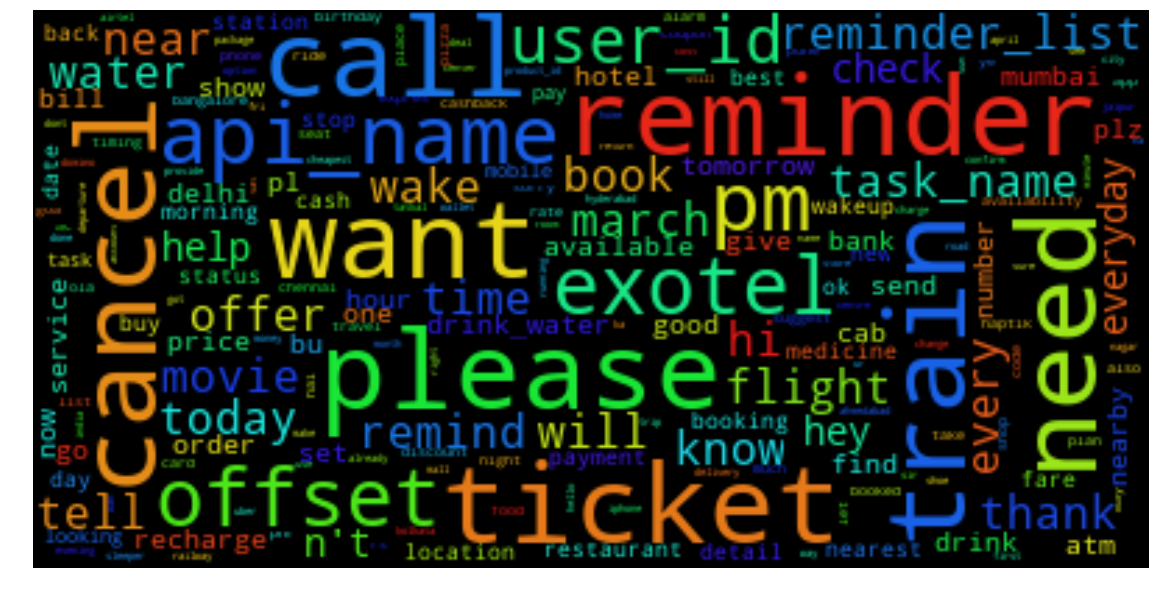

In [17]:
create_word_cloud(X_train_before_stopwordremoval)

In [18]:
sw_curated = ['a9c0', 'f0af5ee2b89b', '676951', 'hi', '727893', '55616', 'task_nam',
              'user_id', '50', '16', 'exotel','ok', 'haptik', 'nearbi',
              'api_name', 'offset', 'user_id', '00', 'pleas', 'can', 'pl',
              'drink_water', 'reminer_list', 'trains_api', 'product_id', 
              'I', 'j', 'se', 'sl', '10', 'hai', 'll', 'kya', 'rs', 'sorri',
              'know', '30', 'one', '10 00', 'bu', 'reminder_list',
              'plz', 'everi']
# sw_curated = ['task_name','user_id', 'offset','exotel','ok', 'haptik', 'nearbi',
#               'api_name', 'please', 'drink_water', 'reminder_list']

In [19]:
X_test = preprocess(X_test, custom_stop = sw_curated, stem = True)
X_train = preprocess(X_train, custom_stop = sw_curated, stem = True)

0                               [nearest, metro, station]
1                   [pick, n, drop, service, trough, cab]
2                                      [wants, buy, bick]
3                                           [show, pizza]
4                   [cheapest, package, andaman, nicobar]
5                     [reminde, take, money, mummy, 2:15]
6                                     [yoga, centre, gym]
7                            [cant, found, chinese, menu]
8                             [sorry, help, book, ticket]
9                           [now, want, remove, reminder]
10                                    [xiaomi, redmi, 3s]
11                                [film, releasing, ?, ?]
12                                [hey, want, full, pair]
13                  [ting, 1st, flight, frm, hyd, mumbai]
14      [suggest, slogan, online, shopping, company, n...
15      [need, book, flight, ticket, canada, yyz, airp...
16      [u, gv, running, status, kanchankanya, express...
17            

In [ ]:
# import operator
# from collections import OrderedDict
# freq = np.ravel(train_dtm.sum(axis=0))
# vocab = [v[0] for v in sorted(vect.vocabulary_.items(), key=operator.itemgetter(1))]
# freq_sorted = dict(zip(vocab, freq))
# freq_dict = OrderedDict(sorted(freq_sorted.items(), key=operator.itemgetter(1)))
# wordfreq = pd.DataFrame({'word':freq_dict.keys(), 'count':freq_dict.values()})

In [20]:
X_test[0:5]

0               [nearest, metro, station]
1    [pick, n, drop, servic, trough, cab]
2                       [want, buy, bick]
3                           [show, pizza]
4    [cheapest, packag, andaman, nicobar]
Name: message, dtype: object

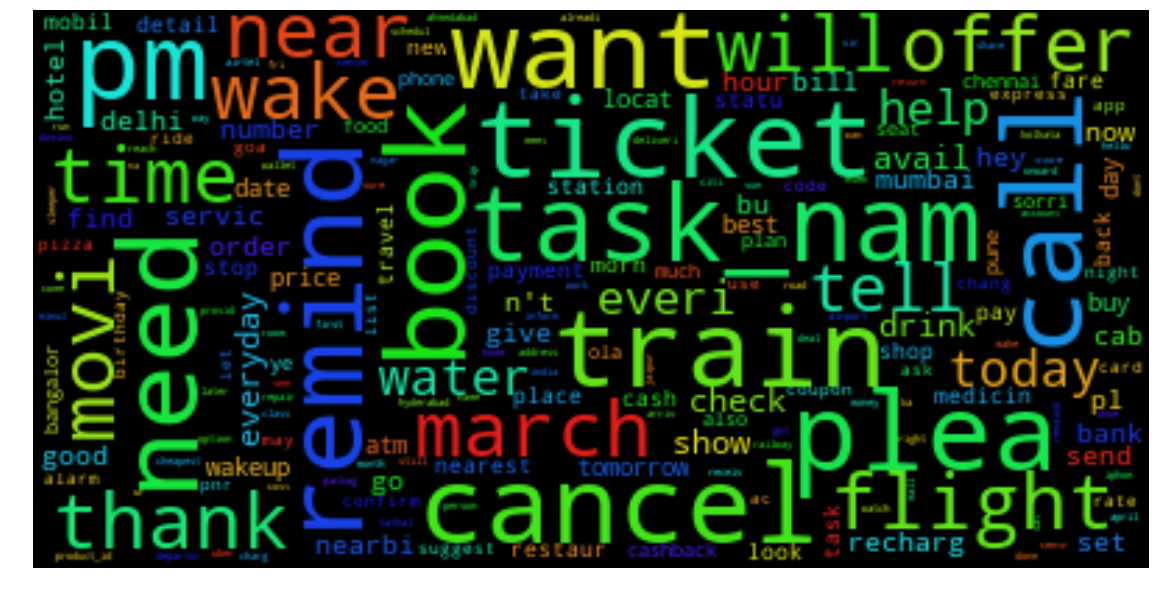

In [21]:
create_word_cloud(X_train)

In [22]:
from sklearn.linear_model import LogisticRegression
classify(X_train,y_train,X_test,y_test,
         model = OneVsRestClassifier(LogisticRegression(penalty='l2',solver='newton-cg',multi_class='multinomial')))

accuracy_label:  0.947811111111
accuracy_subset:  0.6813
classification report: 
              precision    recall  f1-score   support

          0       0.88      0.59      0.71       810
          1       0.82      0.64      0.72       450
          2       0.81      0.32      0.46       371
          3       0.92      0.81      0.86       893
          4       0.85      0.85      0.85      2138
          5       0.74      0.61      0.67       807
          6       0.87      0.57      0.69       637
          7       0.91      0.65      0.76      3282
          8       0.94      0.59      0.72      1668

avg / total       0.88      0.67      0.75     11056



In [23]:
classify(X_train,y_train,X_test,y_test,
         model = OneVsRestClassifier(MultinomialNB(alpha = 0.4)))

accuracy_label:  0.939666666667
accuracy_subset:  0.6417
classification report: 
              precision    recall  f1-score   support

          0       0.78      0.66      0.71       810
          1       0.67      0.73      0.70       450
          2       0.57      0.45      0.51       371
          3       0.88      0.81      0.85       893
          4       0.79      0.88      0.83      2138
          5       0.54      0.68      0.60       807
          6       0.73      0.62      0.67       637
          7       0.89      0.61      0.72      3282
          8       0.87      0.69      0.77      1668

avg / total       0.80      0.70      0.74     11056



In [24]:
from sklearn.ensemble import RandomForestClassifier
classify(X_train,y_train,X_test,y_test,
         model = RandomForestClassifier(n_estimators=50, n_jobs=-1))

accuracy_label:  0.944388888889
accuracy_subset:  0.7307
classification report: 
              precision    recall  f1-score   support

          0       0.77      0.63      0.70       810
          1       0.73      0.70      0.71       450
          2       0.58      0.27      0.37       371
          3       0.85      0.84      0.85       893
          4       0.80      0.85      0.83      2138
          5       0.67      0.62      0.64       807
          6       0.69      0.65      0.67       637
          7       0.84      0.84      0.84      3282
          8       0.92      0.50      0.65      1668

avg / total       0.80      0.73      0.75     11056



In [26]:
from sklearn.ensemble import RandomForestClassifier
classify(X_train,y_train,X_test,y_test,
         model = RandomForestClassifier(n_estimators=200, n_jobs=-1))

accuracy_label:  0.945144444444
accuracy_subset:  0.7323
classification report: 
              precision    recall  f1-score   support

          0       0.78      0.63      0.70       810
          1       0.74      0.68      0.71       450
          2       0.59      0.26      0.36       371
          3       0.86      0.84      0.85       893
          4       0.81      0.86      0.83      2138
          5       0.67      0.62      0.64       807
          6       0.71      0.64      0.67       637
          7       0.83      0.85      0.84      3282
          8       0.92      0.50      0.65      1668

avg / total       0.81      0.73      0.76     11056



In [27]:
classify(X_train,y_train,X_test,y_test,
         model = ExtraTreesClassifier(n_estimators=200, n_jobs=-1))

accuracy_label:  0.944822222222
accuracy_subset:  0.7358
classification report: 
              precision    recall  f1-score   support

          0       0.75      0.63      0.69       810
          1       0.73      0.71      0.72       450
          2       0.55      0.27      0.37       371
          3       0.86      0.85      0.85       893
          4       0.82      0.85      0.83      2138
          5       0.66      0.62      0.64       807
          6       0.71      0.64      0.67       637
          7       0.83      0.84      0.84      3282
          8       0.91      0.53      0.67      1668

avg / total       0.80      0.73      0.76     11056

